In [33]:
import numpy as np
import pandas as pd
import requests
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from plotting import *
%matplotlib inline

# Get the data

In [35]:
complexes = ["CB8-G3", "OA-G3", "OA-G6"]
replicates = range(0, 5)
systems = [i + "-" + str(j) for i in complexes for j in replicates]

## YANK

In [36]:
url = "https://raw.githubusercontent.com/MobleyLab/SAMPL6/update-sampling/host_guest/Analysis/SAMPLing/Data/reference_free_energies.csv"
s = requests.get(url).content
data = s.decode("utf-8").split("\n")

In [37]:
yank_dictionary = {}
for system in systems:
    yank_dictionary[system] = {}
    for line in data:
        fields = line.split(",")
        if re.match(system + "-DG", fields[0]):
            yank_dictionary[system]["y"] = [float(i) for i in fields[1:]]
        if re.match(system + "-n_energy_evaluations", fields[0]):
            yank_dictionary[system]["x"] = [float(i) for i in fields[1:]]


## APR

In [43]:
# This directory has extra sampling.
# prefix = '/home/dslochower/kirkwood/projects/SAMPLing/OA-cut9-extension/'

# This directory (in the local repository) has the data we submitted to the SAMPLing challenge.
prefix = "./OA/"

In [44]:
oa_g3_0_9 = np.genfromtxt(prefix + 'OA-G3-0-ti-quicker.log')
oa_g3_1_9 = np.genfromtxt(prefix + 'OA-G3-1-ti-quicker.log')
oa_g3_2_9 = np.genfromtxt(prefix + 'OA-G3-2-ti-quicker.log')
oa_g3_3_9 = np.genfromtxt(prefix + 'OA-G3-3-ti-quicker.log')
oa_g3_4_9 = np.genfromtxt(prefix + 'OA-G3-4-ti-quicker.log')

oa_g6_0_9 = np.genfromtxt(prefix + 'OA-G6-0-ti-quicker-more.log')
oa_g6_1_9 = np.genfromtxt(prefix + 'OA-G6-1-ti-quicker-more.log')
oa_g6_2_9 = np.genfromtxt(prefix + 'OA-G6-2-ti-quicker-more.log')
oa_g6_3_9 = np.genfromtxt(prefix + 'OA-G6-3-ti-quicker-more.log')
oa_g6_4_9 = np.genfromtxt(prefix + 'OA-G6-4-ti-quicker-more.log')

In [45]:
nines  = [oa_g3_0_9, oa_g3_1_9, oa_g3_2_9, oa_g3_3_9, oa_g3_4_9,
          oa_g6_0_9, oa_g6_1_9, oa_g6_2_9, oa_g6_3_9, oa_g6_4_9]

apr_dictionary = dict()
for index, system in enumerate(['OA-G3-0', 'OA-G3-1', 'OA-G3-2', 'OA-G3-3', 'OA-G3-4', \
                                'OA-G6-0', 'OA-G6-1', 'OA-G6-2', 'OA-G6-3', 'OA-G6-4']):


    apr_dictionary[system] = {}
    apr_dictionary[system]["x"] = (nines[index][:,3] + nines[index][:,6]) * 250
    apr_dictionary[system]["y"] = -1 * (nines[index][:,1] + nines[index][:,4] + nines[index][:,7])
    apr_dictionary[system]["y_sem"] = np.sqrt(nines[index][:,2]**2 + nines[index][:,5]**2)

In [46]:
prefix = './CB8/'

In [47]:
cb8_g3 = np.genfromtxt(prefix + 'cb8-g3.ti-block.converge.dat', dtype=str)
total_time = 2135000000

In [49]:
for system, line in zip(['CB8-G3-0', 'CB8-G3-1', 'CB8-G3-2', 'CB8-G3-3', 'CB8-G3-4',], cb8_g3):
    apr_dictionary[system] = {}
    apr_dictionary[system]["x"] = np.linspace(0, total_time, 100)
    apr_dictionary[system]["y"] = [float(i[:-1]) for i in line[1::2]]
    apr_dictionary[system]["y_sem"] = [float(i[:-1]) for i in line[2::2]]

## Truncate YANK to the end of APR sampling

In [53]:
apr_oa_g3_evaluations = apr_dictionary["OA-G3-0"]["x"][-1]
apr_oa_g6_evaluations = apr_dictionary["OA-G6-0"]["x"][-1]
apr_cb8_g3_evaluations = apr_dictionary["CB8-G3-0"]["x"][-1]

In [62]:
for system in systems:
    print("Sorted? " + str(all(yank_dictionary[system]["x"][i] <= yank_dictionary[system]["x"][i+1] 
        for i in range(len(yank_dictionary[system]["x"])-1))))

Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True
Sorted? True


# Setup plots

In [23]:
def colors(prefix, y_lim):

    fig = plt.figure(figsize=(6 * 1.4 * 2, 6))
    gs = gridspec.GridSpec(1, 2, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    for system in [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']:
        ax1.plot(yank_dictionary[system]["x"], yank_dictionary[system]["y"], lw=2, 
                 label=f"{yank_dictionary[system]['y'][-1]:4.2f}")
        ax2.errorbar(apr_dictionary[system]["x"], apr_dictionary[system]["y"], 
                 apr_dictionary[system]["y_sem"],
                 lw=2,
                 label=f"{apr_dictionary[system]['y'][-1]:4.2f} $\pm$ {apr_dictionary[system]['y_sem'][-1]:4.2f}")

    for axes in [ax1, ax2]:
        axes.set_ylim(y_lim)
        axes.set_xlim(0, yank_dictionary[f"{prefix}-0"]["x"][-1])
        axes.set_xlabel("Energy evaluations")
        axes.set_ylabel("$\Delta$G (kcal/mol)")
        axes.legend(frameon=True, loc='lower right', framealpha=1.0, edgecolor='k')
        

    ax1.set_title(f"YANK ({prefix})")
    ax2.set_title(f"APR ({prefix})")
    paper_plot(fig)

In [24]:
def means(prefix, y_lim):
    
    fig = plt.figure(figsize=(6 * 1.4 * 2, 6))
    gs = gridspec.GridSpec(1, 2, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    
    systems = [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']

    for system in systems:
        ax1.plot(yank_dictionary[system]["x"], yank_dictionary[system]["y"], color="0.5", lw=1)
        ax2.errorbar(apr_dictionary[system]["x"], apr_dictionary[system]["y"], color="0.5", lw=1)
        
    
    
    min_yank_time = np.min([len(yank_dictionary[system]["x"]) for system in systems])
    mean_yank_energy = [np.mean([yank_dictionary[system]["y"][time] for system in systems]) for time in range(min_yank_time)]
    std_dev_yank = [np.std([yank_dictionary[system]["y"][time] for system in systems]) for time in range(min_yank_time)]
    ax1.plot(yank_dictionary[f'{prefix}-0']["x"][0:min_yank_time], mean_yank_energy, color="r", lw=4,
            label=f"{mean_yank_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_yank[-1]:4.2f})")
        
    ax1.fill_between(yank_dictionary[f'{prefix}-0']["x"][0:min_yank_time], 
                     [i - j for i, j in zip(mean_yank_energy, std_dev_yank)], 
                     [i + j for i, j in zip(mean_yank_energy, std_dev_yank)], color='r', alpha=0.4, zorder=999)

        
    min_apr_time = np.min([len(apr_dictionary[system]["x"]) for system in systems])
    mean_apr_energy = [np.mean([apr_dictionary[system]["y"][time] for system in systems]) for time in range(min_apr_time)]
    std_dev_apr = [np.std([apr_dictionary[system]["y"][time] for system in systems]) for time in range(min_apr_time)]

    ax2.plot(apr_dictionary[f'{prefix}-0']["x"][0:min_apr_time], mean_apr_energy, color="r", lw=4, 
             label=f"{mean_apr_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_apr[-1]:4.2f})")
    ax2.fill_between(apr_dictionary[f'{prefix}-0']["x"][0:min_yank_time], 
                     [i - j for i, j in zip(mean_apr_energy, std_dev_apr)], 
                     [i + j for i, j in zip(mean_apr_energy, std_dev_apr)], color='r', alpha=0.4, zorder=999)


    for axes in [ax1, ax2]:
        axes.set_ylim(y_lim)
        axes.set_xlim(0, yank_dictionary[system]["x"][-1])
        axes.set_xlabel("Energy evaluations")
        axes.set_ylabel("$\Delta$G (kcal/mol)")
        axes.legend(frameon=True, loc='lower right', framealpha=1.0, edgecolor='k')

        # axes.set_xlim(0, 1e9)
        
    ax1.set_title(f"YANK ({prefix})")
    ax2.set_title(f"APR ({prefix})")
    paper_plot(fig)

In [25]:
def simple_means(prefix, y_lim):
    
    fig = plt.figure(figsize=(6 * 1.4, 6))
    gs = gridspec.GridSpec(1, 1, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])
    
    systems = [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']

    min_yank_time = np.min([len(yank_dictionary[system]["x"]) for system in systems])
    mean_yank_energy = [np.mean([yank_dictionary[system]["y"][time] for system in systems]) for time in range(min_yank_time)]
    std_dev_yank = [np.std([yank_dictionary[system]["y"][time] for system in systems]) for time in range(min_yank_time)]
    ax1.plot(yank_dictionary[f'{prefix}-0']["x"][0:min_yank_time], mean_yank_energy, color="r", lw=4,
            label=f"{mean_yank_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_yank[-1]:4.2f})")
        
        
    min_apr_time = np.min([len(apr_dictionary[system]["x"]) for system in systems])
    mean_apr_energy = [np.mean([apr_dictionary[system]["y"][time] for system in systems]) for time in range(min_apr_time)]
    std_dev_apr = [np.std([apr_dictionary[system]["y"][time] for system in systems]) for time in range(min_apr_time)]

    ax1.plot(apr_dictionary[f'{prefix}-0']["x"][0:min_apr_time], mean_apr_energy, color="b", lw=4, 
             label=f"{mean_apr_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_apr[-1]:4.2f})")

    ax1.set_ylim(y_lim)
    ax1.set_xlim(0, yank_dictionary[f'{prefix}-0']["x"][min_yank_time])
    ax1.set_xlabel("Energy evaluations")
    ax1.set_ylabel("$\Delta$G (kcal/mol)")
    ax1.legend(frameon=True, loc='lower right', framealpha=1.0, edgecolor='k')

    paper_plot(fig)

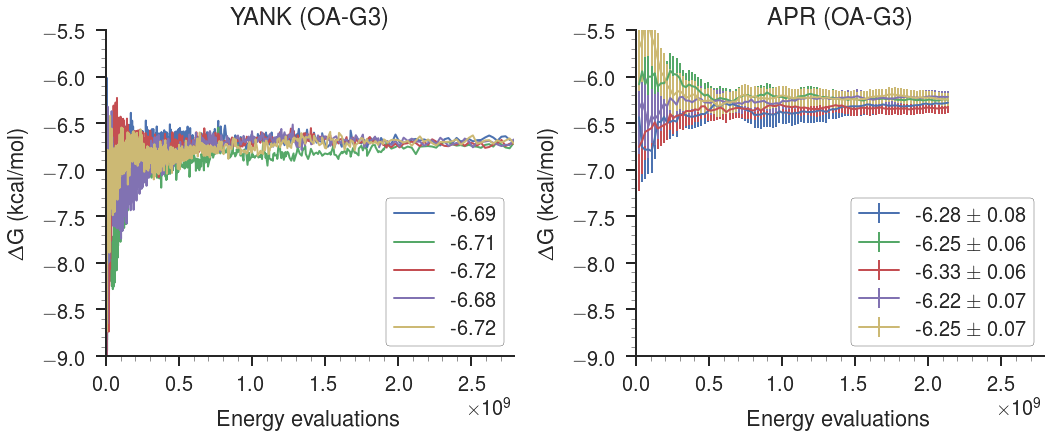

In [26]:
colors("OA-G3", (-9, -5.5))
# Leave off the error bars from this plot

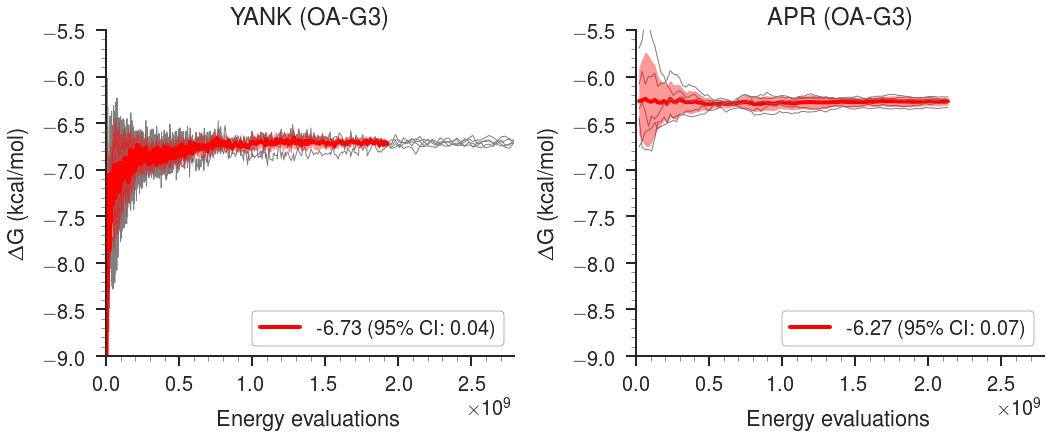

In [27]:
means("OA-G3", (-9, -5.5))

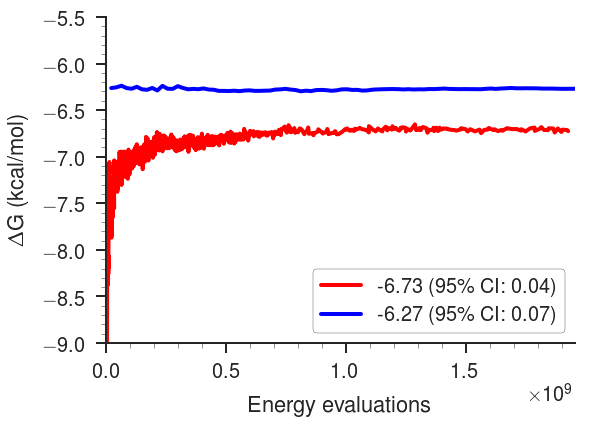

In [28]:
simple_means("OA-G3", (-9, -5.5))
# Plot std dev of the means as a function of energy evaluations

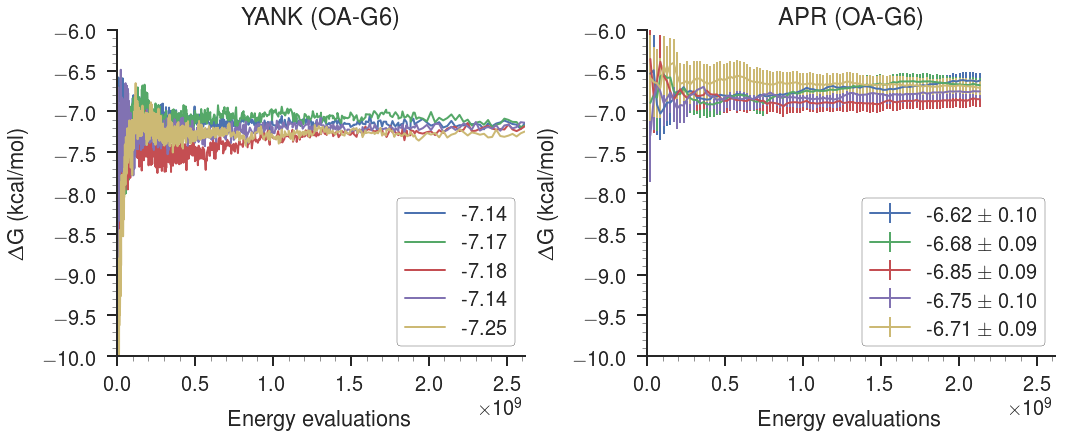

In [29]:
colors("OA-G6", (-10, -6))

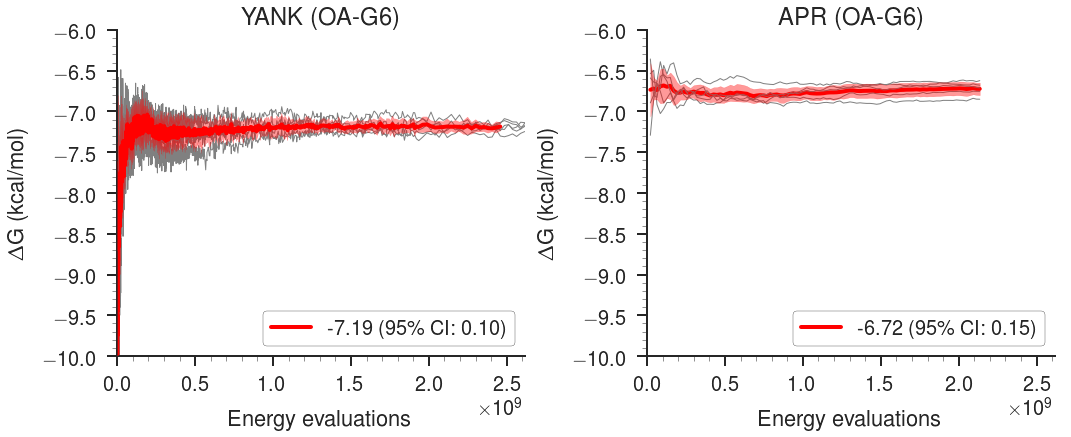

In [30]:
means("OA-G6", (-10, -6))

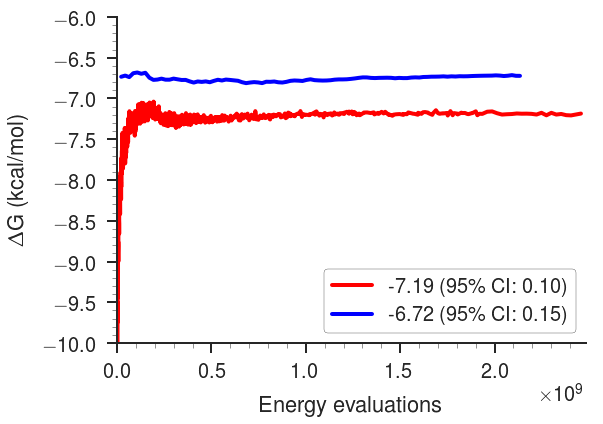

In [31]:
simple_means("OA-G6", (-10, -6))

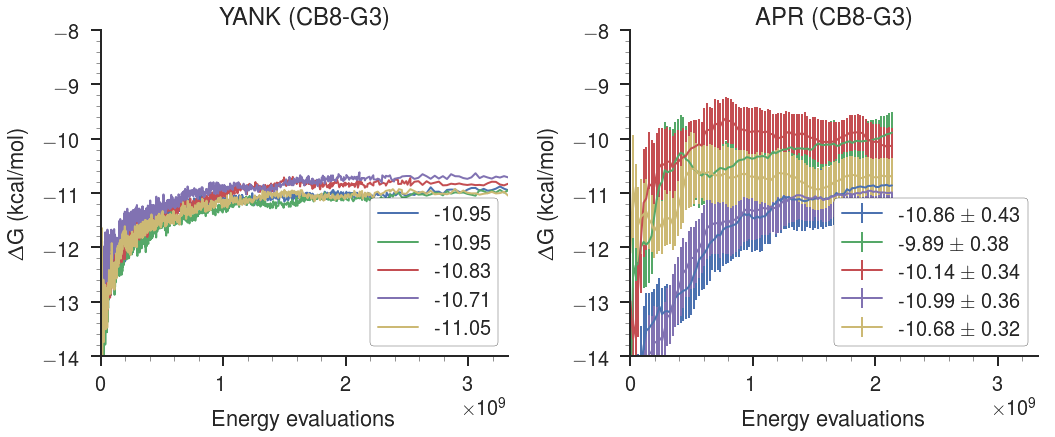

In [329]:
colors("CB8-G3", (-14, -8))

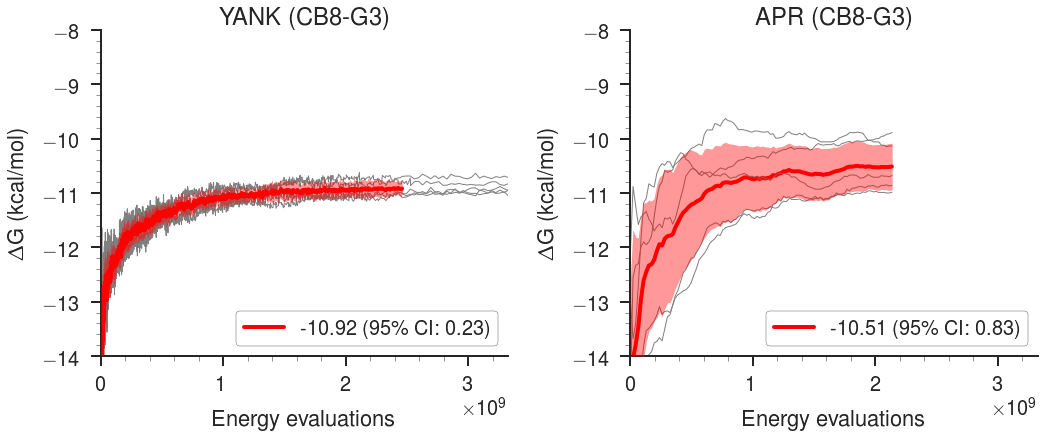

In [330]:
means("CB8-G3", (-14, -8))

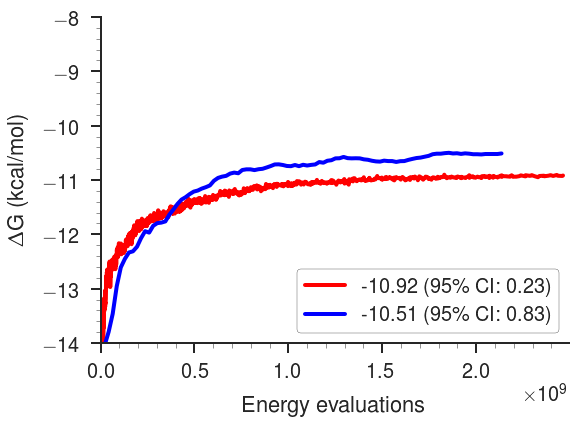

In [350]:
simple_means("CB8-G3", (-14, -8))